# UCI Breast Cancer Dataset - Decision Tree Model Training

## Table of Contents
1. Load Preprocessed Data
2. Train Decision Tree Model
3. Evaluate Performance
4. Confusion Matrix & Classification Report
5. ROC Curve Analysis
6. Feature Importance Analysis
7. Hyperparameter Tuning with Grid Search
8. Visualize Decision Tree
9. Save Best Model
10. Make Predictions


## 1. Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from time import time

# Decision Tree and model selection
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


## 2. Loading Previously Preprocessed Data


In [ ]:
# Load preprocessed data
print("Loading preprocessed data...")

X_train = pd.read_csv('data/processed/X_train_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

# Load feature names
with open('data/processed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines() if line.strip()]

# Convert to numpy arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"✓ Data loaded successfully!")
print(f"\nDataset Information:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"\nClass Distribution:")
print(f"  Training - Benign: {np.sum(y_train == 0)}, Malignant: {np.sum(y_train == 1)}")
print(f"  Testing - Benign: {np.sum(y_test == 0)}, Malignant: {np.sum(y_test == 1)}")


## 3. Train Basic Decision Tree Model


In [ ]:
# Create and train Decision Tree model
print("Training Decision Tree model...")
print("="*60)

start_time = time()

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

training_time = time() - start_time

print(f"Model trained successfully in {training_time:.2f} seconds!")
print(f"\nModel Parameters:")
print(f"  Max Depth: {dt_model.max_depth}")
print(f"  Min Samples Split: {dt_model.min_samples_split}")
print(f"  Min Samples Leaf: {dt_model.min_samples_leaf}")
print(f"  Criterion: {dt_model.criterion}")
print(f"  Number of Leaves: {dt_model.get_n_leaves()}")
print(f"  Tree Depth: {dt_model.get_depth()}")


## 4. Evaluate Model and Feature Importance


In [ ]:
# Make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*60)
print("DECISION TREE MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")
print("="*60)

# Feature Importance
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importances.head(10).to_string(index=False))


## 5. Hyperparameter Tuning


In [ ]:
print("Performing Grid Search for best hyperparameters...")

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV F1-score: {grid_search.best_score_:.4f}")


## 6. Save the Best Model


In [ ]:
# Evaluate optimized model
y_pred_opt = best_dt_model.predict(X_test)
y_pred_proba_opt = best_dt_model.predict_proba(X_test)[:, 1]

accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_opt)

print("\n" + "="*60)
print("OPTIMIZED DECISION TREE PERFORMANCE")
print("="*60)
print(f"Accuracy:  {accuracy_opt:.4f} ({accuracy_opt*100:.2f}%)")
print(f"Precision: {precision_opt:.4f} ({precision_opt*100:.2f}%)")
print(f"Recall:    {recall_opt:.4f} ({recall_opt*100:.2f}%)")
print(f"F1-Score:  {f1_opt:.4f} ({f1_opt*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc_opt:.4f} ({roc_auc_opt*100:.2f}%)")
print("="*60)

# Save model
os.makedirs('models', exist_ok=True)
model_filename = 'models/decision_tree_breast_cancer_model.pkl'
joblib.dump(best_dt_model, model_filename)

metadata = {
    'model_type': 'Decision Tree Classifier',
    'criterion': best_dt_model.criterion,
    'max_depth': best_dt_model.max_depth,
    'min_samples_split': best_dt_model.min_samples_split,
    'min_samples_leaf': best_dt_model.min_samples_leaf,
    'max_features': best_dt_model.max_features,
    'n_leaves': best_dt_model.get_n_leaves(),
    'tree_depth': best_dt_model.get_depth(),
    'accuracy': accuracy_opt,
    'precision': precision_opt,
    'recall': recall_opt,
    'f1_score': f1_opt,
    'roc_auc': roc_auc_opt,
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'features': X_train.shape[1]
}

metadata_filename = 'models/decision_tree_model_metadata.pkl'
joblib.dump(metadata, metadata_filename)

print(f"\n✓ Model saved to: {model_filename}")
print(f"✓ Metadata saved to: {metadata_filename}")


# UCI Breast Cancer Dataset - Decision Tree Model Training

## Table of Contents
1. Load Preprocessed Data
2. Train Decision Tree Model
3. Evaluate Performance
4. Confusion Matrix & Classification Report
5. ROC Curve Analysis
6. Feature Importance Analysis
7. Hyperparameter Tuning with Grid Search
8. Visualize Decision Tree
9. Save Best Model
10. Make Predictions


## 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from time import time

# Decision Tree and model selection
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, cross_val_score

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Loading Previously Preprocessed Data


In [2]:
# Load preprocessed data
print("Loading preprocessed data...")

X_train = pd.read_csv('data/processed/X_train_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

# Load feature names
with open('data/processed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines() if line.strip()]

# Convert to numpy arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"✓ Data loaded successfully!")
print(f"\nDataset Information:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"\nClass Distribution:")
print(f"  Training - Benign: {np.sum(y_train == 0)}, Malignant: {np.sum(y_train == 1)}")
print(f"  Testing - Benign: {np.sum(y_test == 0)}, Malignant: {np.sum(y_test == 1)}")


Loading preprocessed data...
✓ Data loaded successfully!

Dataset Information:
  Training samples: 455
  Testing samples: 114
  Number of features: 30

Class Distribution:
  Training - Benign: 285, Malignant: 170
  Testing - Benign: 72, Malignant: 42


## 3. Train Basic Decision Tree Model


In [3]:
# Create and train Decision Tree model
print("Training Decision Tree model...")
print("="*60)

start_time = time()

# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

training_time = time() - start_time

print(f"Model trained successfully in {training_time:.2f} seconds!")
print(f"\nModel Parameters:")
print(f"  Max Depth: {dt_model.max_depth}")
print(f"  Min Samples Split: {dt_model.min_samples_split}")
print(f"  Min Samples Leaf: {dt_model.min_samples_leaf}")
print(f"  Criterion: {dt_model.criterion}")
print(f"  Number of Leaves: {dt_model.get_n_leaves()}")
print(f"  Tree Depth: {dt_model.get_depth()}")


Training Decision Tree model...
Model trained successfully in 0.05 seconds!

Model Parameters:
  Max Depth: None
  Min Samples Split: 2
  Min Samples Leaf: 1
  Criterion: gini
  Number of Leaves: 24
  Tree Depth: 8


## 4. Make Predictions and Evaluate Performance


In [5]:
# Make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*60)
print("DECISION TREE MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")
print("="*60)

# Cross-validation score
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n5-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



DECISION TREE MODEL PERFORMANCE

Accuracy:  0.9298 (92.98%)
Precision: 0.9048 (90.48%)
Recall:    0.9048 (90.48%)
F1-Score:  0.9048 (90.48%)
ROC-AUC:   0.9246 (92.46%)

5-Fold Cross-Validation Accuracy: 0.9319 (+/- 0.0281)


## 5. Confusion Matrix Visualization


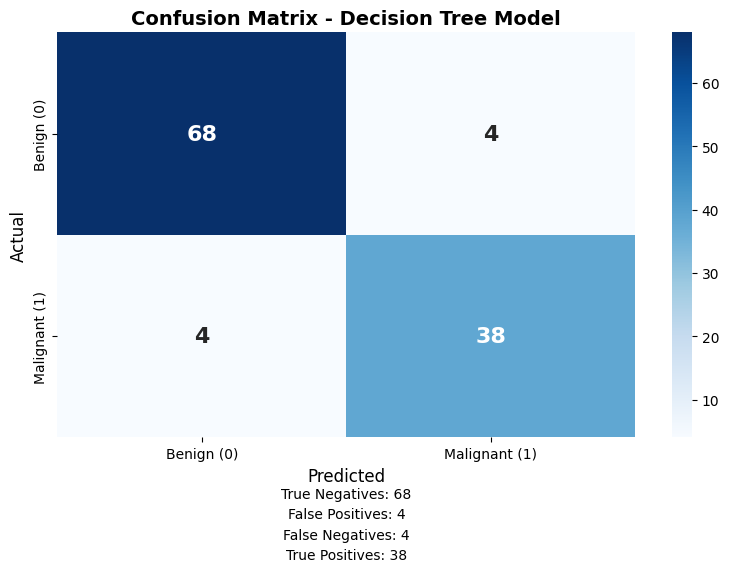


Confusion Matrix Breakdown:
  True Negatives (Correct Benign):    68
  False Positives (Benign as Malignant): 4
  False Negatives (Malignant as Benign): 4
  True Positives (Correct Malignant):  38


In [7]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Confusion Matrix - Decision Tree Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add text annotations
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, -0.15, f'True Negatives: {tn}', ha='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.20, f'False Positives: {fp}', ha='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.25, f'False Negatives: {fn}', ha='center', transform=plt.gca().transAxes, fontsize=10)
plt.text(0.5, -0.30, f'True Positives: {tp}', ha='center', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Correct Benign):    {tn}")
print(f"  False Positives (Benign as Malignant): {fp}")
print(f"  False Negatives (Malignant as Benign): {fn}")
print(f"  True Positives (Correct Malignant):  {tp}")


## 6. Detailed Classification Report


In [8]:
# Print detailed classification report
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Benign (0)', 'Malignant (1)'],
                          digits=4))
print("="*60)



DETAILED CLASSIFICATION REPORT
               precision    recall  f1-score   support

   Benign (0)     0.9444    0.9444    0.9444        72
Malignant (1)     0.9048    0.9048    0.9048        42

     accuracy                         0.9298       114
    macro avg     0.9246    0.9246    0.9246       114
 weighted avg     0.9298    0.9298    0.9298       114



## 7. ROC Curve Analysis


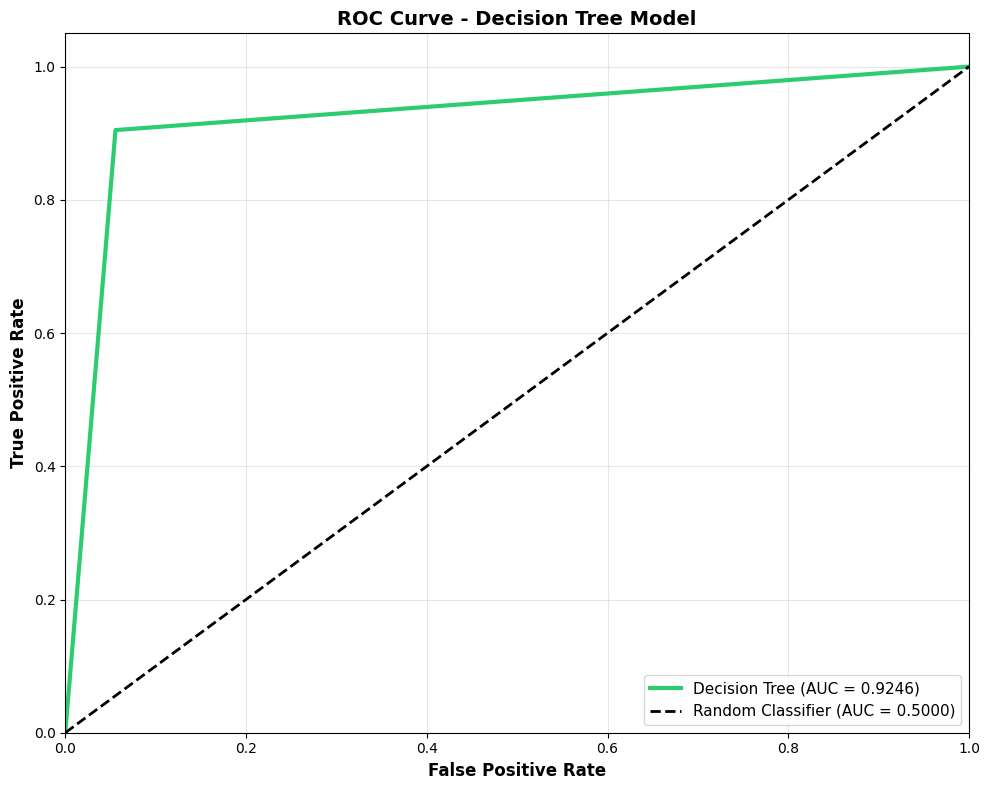


ROC-AUC Score: 0.9246
  This means the model has a 92.46% chance of correctly distinguishing
  between benign and malignant cases.


In [10]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='#2ecc71', linewidth=3, label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Decision Tree Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nROC-AUC Score: {roc_auc:.4f}")
print(f"  This means the model has a {roc_auc*100:.2f}% chance of correctly distinguishing")
print(f"  between benign and malignant cases.")


## 8. Feature Importance Analysis

One of the key advantages of Decision Trees is interpretability through feature importance.



FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
             feature  importance
     perimeter_worst    0.727477
concave points_worst    0.078970
    smoothness_worst    0.040833
        texture_mean    0.037871
       texture_worst    0.022545
           area_mean    0.022452
        radius_worst    0.017530
          area_worst    0.015606
 concave points_mean    0.013416
        concavity_se    0.007043


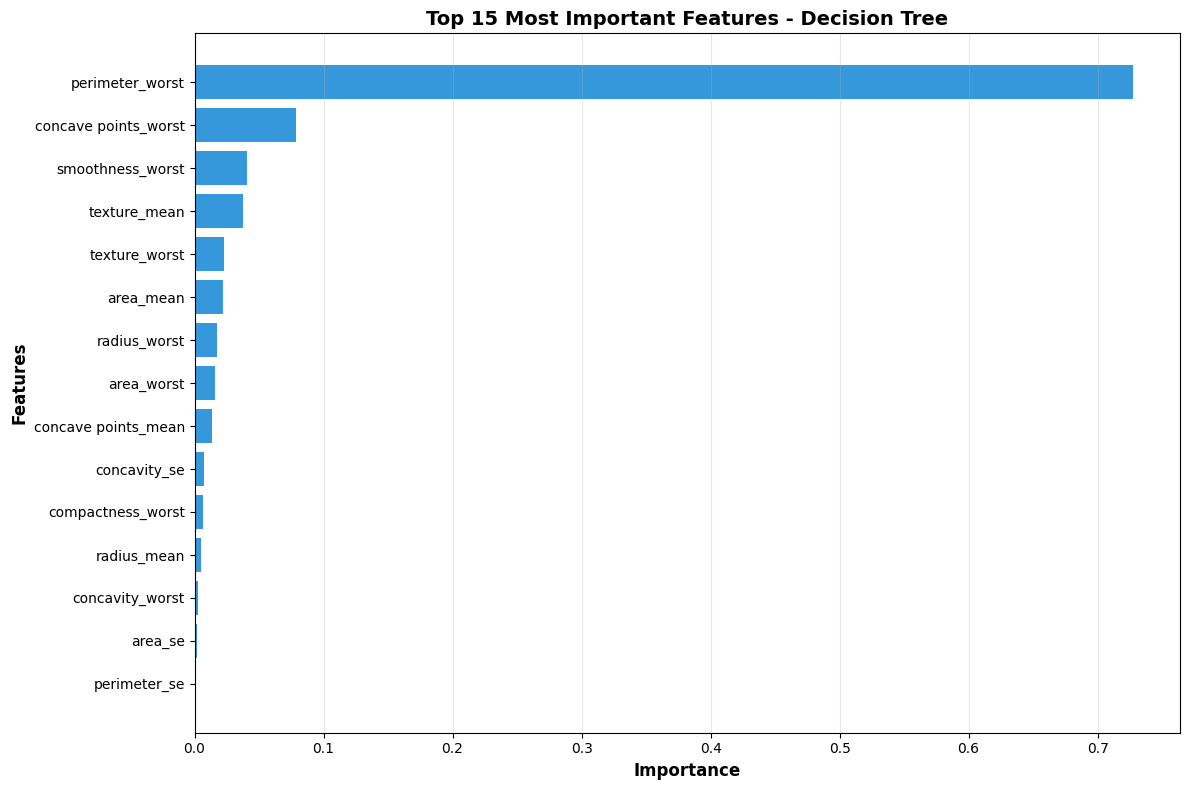

In [11]:
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)
print("\nTop 10 Most Important Features:")
print(feature_importances.head(10).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importances.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='#3498db')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Hyperparameter Tuning with Grid Search


In [12]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*60)

# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

print("\nSearching for best hyperparameters...")
print(f"Parameter grid: {param_grid}")
print(f"This may take a few minutes...\n")

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

start_time = time()
grid_search.fit(X_train, y_train)
search_time = time() - start_time

print(f"\n✓ Grid search completed in {search_time:.2f} seconds!")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation F1-score: {grid_search.best_score_:.4f}")



HYPERPARAMETER TUNING WITH GRID SEARCH

Searching for best hyperparameters...
Parameter grid: {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 10, 15, 20, None], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 2, 4, 8], 'max_features': ['sqrt', 'log2', None]}
This may take a few minutes...

Fitting 5 folds for each of 672 candidates, totalling 3360 fits

✓ Grid search completed in 25.73 seconds!

Best parameters found:
  criterion: entropy
  max_depth: 7
  max_features: None
  min_samples_leaf: 2
  min_samples_split: 5

Best cross-validation F1-score: 0.9297


## 10. Evaluate Optimized Model


In [13]:
# Get best model from grid search
best_dt_model = grid_search.best_estimator_

# Make predictions with the optimized model
y_pred_optimized = best_dt_model.predict(X_test)
y_pred_proba_optimized = best_dt_model.predict_proba(X_test)[:, 1]

# Calculate metrics for optimized model
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_optimized)

print("\n" + "="*60)
print("OPTIMIZED DECISION TREE MODEL PERFORMANCE")
print("="*60)
print(f"\nAccuracy:  {accuracy_opt:.4f} ({accuracy_opt*100:.2f}%)")
print(f"Precision: {precision_opt:.4f} ({precision_opt*100:.2f}%)")
print(f"Recall:    {recall_opt:.4f} ({recall_opt*100:.2f}%)")
print(f"F1-Score:  {f1_opt:.4f} ({f1_opt*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc_opt:.4f} ({roc_auc_opt*100:.2f}%)")
print("="*60)

# Print optimized tree structure
print(f"\nOptimized Tree Structure:")
print(f"  Number of Leaves: {best_dt_model.get_n_leaves()}")
print(f"  Tree Depth: {best_dt_model.get_depth()}")

# Compare with the basic model
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Basic DT': [accuracy, precision, recall, f1, roc_auc],
    'Optimized DT': [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt],
    'Improvement': [
        accuracy_opt - accuracy,
        precision_opt - precision,
        recall_opt - recall,
        f1_opt - f1,
        roc_auc_opt - roc_auc
    ]
})
print(comparison_df.to_string(index=False))
print("="*60)



OPTIMIZED DECISION TREE MODEL PERFORMANCE

Accuracy:  0.9561 (95.61%)
Precision: 1.0000 (100.00%)
Recall:    0.8810 (88.10%)
F1-Score:  0.9367 (93.67%)
ROC-AUC:   0.9396 (93.96%)

Optimized Tree Structure:
  Number of Leaves: 16
  Tree Depth: 7

PERFORMANCE COMPARISON
   Metric  Basic DT  Optimized DT  Improvement
 Accuracy  0.929825      0.956140     0.026316
Precision  0.904762      1.000000     0.095238
   Recall  0.904762      0.880952    -0.023810
 F1-Score  0.904762      0.936709     0.031947
  ROC-AUC  0.924603      0.939649     0.015046


## 11. Visualize Performance Comparison


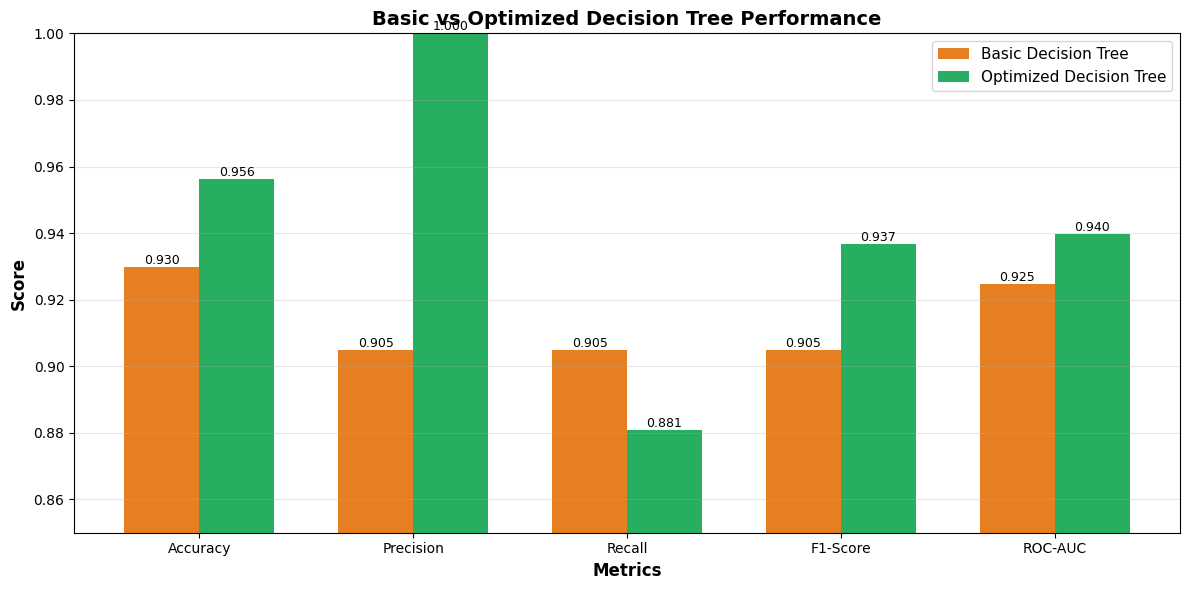

In [14]:
# Create comparison visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
basic_scores = [accuracy, precision, recall, f1, roc_auc]
optimized_scores = [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, basic_scores, width, label='Basic Decision Tree', color='#e67e22')
bars2 = ax.bar(x + width/2, optimized_scores, width, label='Optimized Decision Tree', color='#27ae60')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Basic vs Optimized Decision Tree Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.set_ylim([0.85, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 12. Visualize Optimized Decision Tree


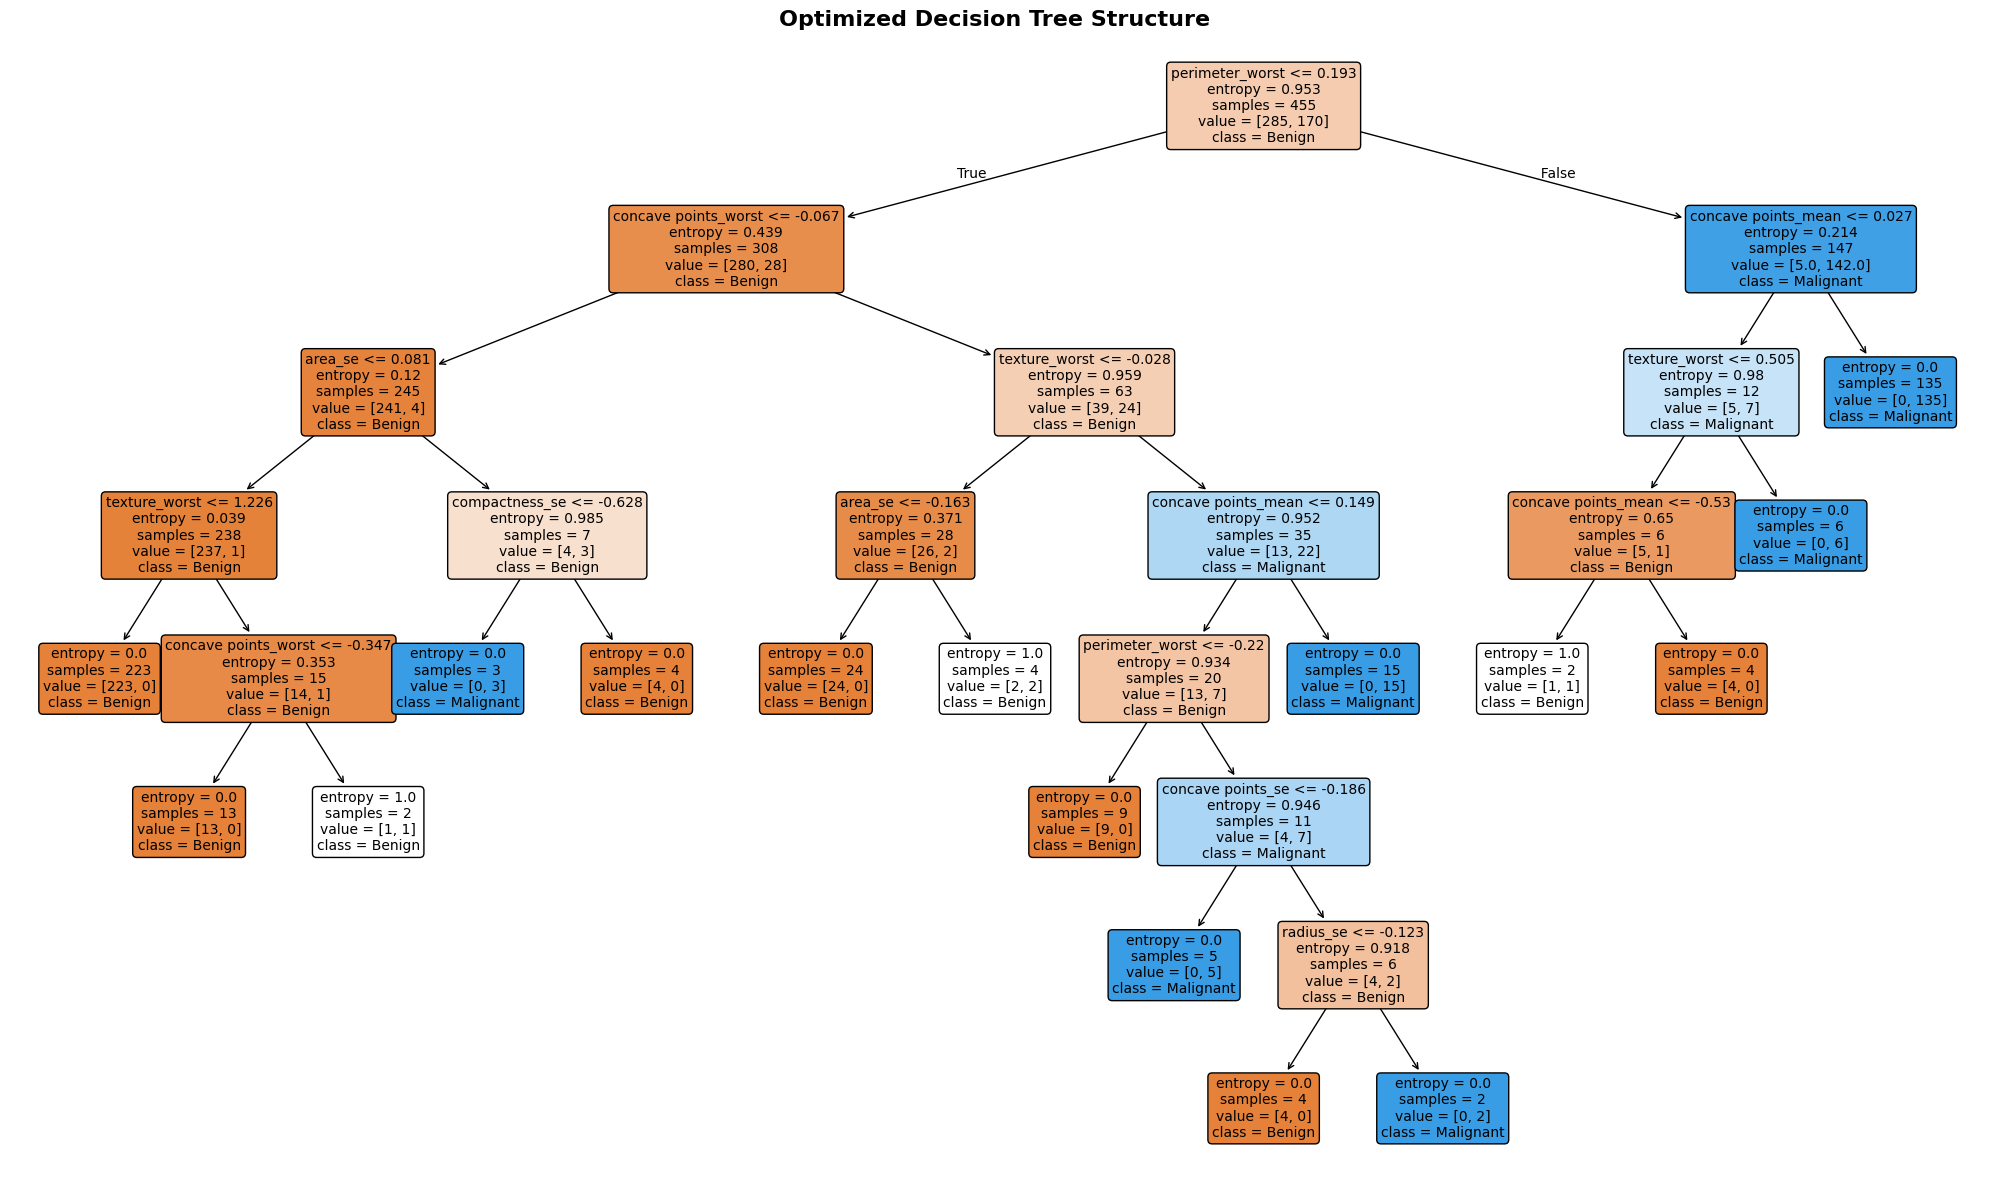


Note: If the tree is too deep, the visualization may be hard to read.
Consider using a smaller max_depth for better visualization.


In [15]:
# Visualize the decision tree structure
plt.figure(figsize=(20, 12))
plot_tree(best_dt_model, 
          feature_names=feature_names,
          class_names=['Benign', 'Malignant'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Optimized Decision Tree Structure', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNote: If the tree is too deep, the visualization may be hard to read.")
print("Consider using a smaller max_depth for better visualization.")


## 13. Feature Importance - Optimized Model



FEATURE IMPORTANCE - OPTIMIZED MODEL

Top 10 Most Important Features:
             feature  importance
     perimeter_worst    0.646401
concave points_worst    0.114599
 concave points_mean    0.085133
       texture_worst    0.067132
             area_se    0.046109
      compactness_se    0.016197
           radius_se    0.012940
   concave points_se    0.011490
           area_mean    0.000000
     smoothness_mean    0.000000


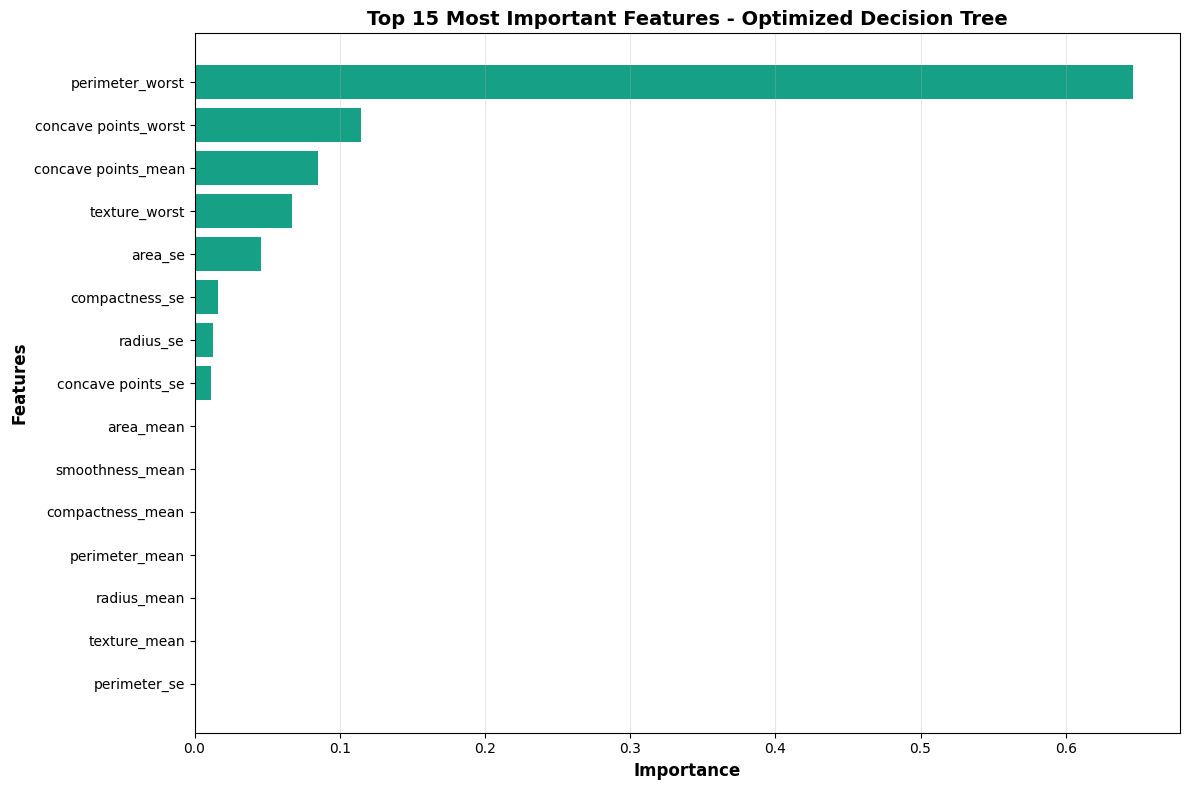

In [16]:
# Get feature importances from optimized model
feature_importances_opt = pd.DataFrame({
    'feature': feature_names,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE - OPTIMIZED MODEL")
print("="*60)
print("\nTop 10 Most Important Features:")
print(feature_importances_opt.head(10).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features_opt = feature_importances_opt.head(15)
plt.barh(range(len(top_features_opt)), top_features_opt['importance'], color='#16a085')
plt.yticks(range(len(top_features_opt)), top_features_opt['feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features - Optimized Decision Tree', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 14. Save the Best Model


In [17]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the optimized model
model_filename = 'models/decision_tree_breast_cancer_model.pkl'
joblib.dump(best_dt_model, model_filename)

# Save model metadata
metadata = {
    'model_type': 'Decision Tree Classifier',
    'criterion': best_dt_model.criterion,
    'max_depth': best_dt_model.max_depth,
    'min_samples_split': best_dt_model.min_samples_split,
    'min_samples_leaf': best_dt_model.min_samples_leaf,
    'max_features': best_dt_model.max_features,
    'n_leaves': best_dt_model.get_n_leaves(),
    'tree_depth': best_dt_model.get_depth(),
    'accuracy': accuracy_opt,
    'precision': precision_opt,
    'recall': recall_opt,
    'f1_score': f1_opt,
    'roc_auc': roc_auc_opt,
    'training_samples': len(X_train),
    'testing_samples': len(X_test),
    'features': X_train.shape[1]
}

metadata_filename = 'models/decision_tree_model_metadata.pkl'
joblib.dump(metadata, metadata_filename)

print("\n" + "="*60)
print("MODEL SAVED SUCCESSFULLY")
print("="*60)
print(f"✓ Model saved to: {model_filename}")
print(f"✓ Metadata saved to: {metadata_filename}")
print("\nModel Summary:")
for key, value in metadata.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")



MODEL SAVED SUCCESSFULLY
✓ Model saved to: models/decision_tree_breast_cancer_model.pkl
✓ Metadata saved to: models/decision_tree_model_metadata.pkl

Model Summary:
  model_type: Decision Tree Classifier
  criterion: entropy
  max_depth: 7
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: None
  n_leaves: 16
  tree_depth: 7
  accuracy: 0.9561
  precision: 1.0000
  recall: 0.8810
  f1_score: 0.9367
  roc_auc: 0.9396
  training_samples: 455
  testing_samples: 114
  features: 30


## 15. Make Predictions on New Data


In [ ]:
def predict_breast_cancer(features, model_path='models/decision_tree_breast_cancer_model.pkl', 
                          scaler_path='data/processed/scaler.pkl'):
    """
    Predict breast cancer diagnosis for a new patient using Decision Tree.
    
    Parameters:
    -----------
    features : array-like
        Array of 30 feature values (must be in original scale, not scaled)
    model_path : str
        Path to the saved Decision Tree model
    scaler_path : str
        Path to the saved scaler
    
    Returns:
    --------
    prediction : int
        0 for Benign, 1 for Malignant
    probability : array
        Probability for each class [P(Benign), P(Malignant)]
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Reshape features if needed
    if len(features) == 30:
        features = np.array(features).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0]
    
    # Interpret result
    diagnosis = "Malignant (Cancer)" if prediction == 1 else "Benign (No Cancer)"
    confidence = probability[prediction] * 100
    
    print("\n" + "="*60)
    print("PREDICTION RESULT (Decision Tree)")
    print("="*60)
    print(f"Diagnosis: {diagnosis}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"\nProbabilities:")
    print(f"  Benign:    {probability[0]*100:.2f}%")
    print(f"  Malignant: {probability[1]*100:.2f}%")
    print("="*60)
    
    return prediction, probability


# Test with a sample from test set
print("\nTesting prediction function with a sample from test set:")
sample_features = X_test.iloc[0].values
actual_label = "Malignant" if y_test[0] == 1 else "Benign"
print(f"Actual diagnosis: {actual_label}")

prediction, probability = predict_breast_cancer(sample_features)


## Summary

This notebook trained and evaluated a Decision Tree classifier on the UCI Breast Cancer dataset.

### Key Advantages of Decision Trees:
1. **Interpretability**: Easy to understand and visualize
2. **Feature Importance**: Automatically identifies most important features
3. **No Feature Scaling Required**: Works with raw or scaled data
4. **Fast Training**: Quick to train and predict

### Key Disadvantages:
1. **Overfitting**: Prone to overfitting without proper pruning
2. **Instability**: Small changes in data can lead to different trees
3. **Bias**: Can be biased toward features with more levels

### Next Steps:
- Consider ensemble methods (Random Forest, Gradient Boosting) for better performance
- Compare Decision Tree performance with SVM and other models
- Experiment with different hyperparameter combinations
